## Pytorch with MNIST Dataset

Outline:
- Dataset
- Data Loaders
- Training a model
- TensorBoard
- Adversial Examples

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# Image display
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary
import shutil
import math

### MNIST Dataset
The MNIST database of handwritten digits that has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting.

Each example comprises of a single channel 28×28 grayscale image and an associated label from one of 10 classes.

In [2]:
# Repeatability of results
torch.manual_seed(1)

# We want to train our model on a hardware accelerator like the GPU, if it is available.
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using {device} device")

# The number of images in a mini-batch
batch_size = 64

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 2,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

Using cuda device


## Tensorboard 
Framework that provides visualization and tooling needed for machine learning experimentation. We will use Tensorboard with this notebook [link](https://www.tensorflow.org/tensorboard/)

## Loading a Dataset
PyTorch provides two data primitives: ``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``
that allow you to use pre-loaded datasets as well as your own data.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset`` to enable easy access to the samples.

In [3]:
# Gather datasets and prepare them for consumption
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

# Store separate training and validations splits in ./data
training_set = torchvision.datasets.MNIST('./data',
    download=True,
    train=True,
    transform=transform)

validation_set = torchvision.datasets.MNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set, **train_kwargs)

validation_loader = torch.utils.data.DataLoader(validation_set, **test_kwargs)

# Class labels
classes = ('Zero', 'One', 'Two', 'Three', 'Four', 'Five',
        'Six', 'Seven', 'Eight', 'Nine')

# print the dataset
print(f'Size of training set = {len(training_set)}')
print(f'Size of validation set = {len(validation_set)}')
# print for dataset loader
print(f'Size of training set = {len(training_loader)}')
print(f'Size of validation set = {len(validation_loader)}')

Size of training set = 60000
Size of validation set = 10000
Size of training set = 938
Size of validation set = 157


### Tensorboard Plot Images

Plot the images in one batch on Tensorboard.

One Batch Dimension = torch.Size([64, 1, 28, 28]), Labels Dimension = torch.Size([64])


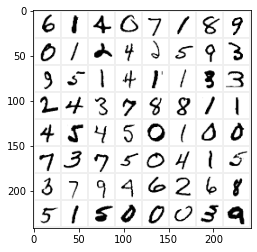

In [4]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 0.3081 + 0.1307    # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')

# Extract a batch of images
dataiter = iter(training_loader)
images, labels = dataiter.next()

print(f'One Batch Dimension = {images.shape}, Labels Dimension = {labels.shape}')

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

# Default log_dir argument is "runs" - but it's good to be specific
shutil.rmtree('runs/mnist_experiment_1')
# torch.utils.tensorboard.SummaryWriter is imported above
writer = SummaryWriter('runs/mnist_experiment_1')

# Write image data to TensorBoard log dir
writer.add_image(f'{batch_size} MNIST Images', img_grid)
writer.flush()

### Tensorboard Projecting 

Project the embeddings to a lower dimensional space

In [5]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=500):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets, 1000)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()

In [6]:
#%tensorboard --logdir runs

## Model Definition

Define our neural network by subclassing ``nn.Module``, and initialize the neural network layers in ``__init__``. Every ``nn.Module`` subclass implements
the operations on input data in the ``forward`` method.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)          # 64x32x26x26
        x = F.relu(x)              # 64x32x26x26
        x = self.conv2(x)          # 64x64x24x24
        x = F.relu(x)              # 64x64x24x24
        x = F.max_pool2d(x, 2)     # 64x64x12x12
        x = self.dropout1(x)       # 64x64x12x12
        x = torch.flatten(x, 1)    # 64x(64*12*12) or 64x9216
        x = self.fc1(x)            # 64x128
        x = F.relu(x)              # 64x128
        x = self.dropout2(x)       # 64x128
        x = self.fc2(x)            # 64x10
        output = F.log_softmax(x, dim=1)  
        return output

# We create an instance of ``NeuralNetwork``, and move it to the ``device``, and print its structure.

net = Net().to(device)
summary(net, (1, 28, 28))

# General Formula : ((m * n * d)+1)* k)
# width m, height n, previous layer’s filters d and filters k in the current layer.
# 2d conv layers
# 320 = (( 3 * 3 * 1) + 1)*32 
# 18,496 = ((3 * 3 * 32) + 1) * 64
# Linear Layers
# 1,179,776 = (9216 + 1)*128
# 1290 = (128+1)*10

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


### Tensorboard Graph Visualisations

Visualizing the model graph and its layers

In [8]:
# Again, grab a single mini-batch of images
dataiter = iter(training_loader)
images, labels = dataiter.next()
images = images.to(device)
# add_graph() will trace the sample input through your model,
# and render it as a graph.
writer.add_graph(net, images)
writer.flush()

## Training the Model

In [9]:
epochs = 14
print(f'Number of Epochs = {epochs}')
log_interval = 200
learning_rate = 1.0
gamma = 0.7

# torch.optim is a package implementing various optimization algorithms. An optimizer object 
# will hold the current state and will update the parameters based on the computed gradients.
optimizer = optim.Adadelta(net.parameters(), lr=learning_rate)

# torch.optim.lr_scheduler provides several methods to adjust the learning rate based on the number of epochs.
# Decays the learning rate of each parameter group by gamma every step_size epochs.
# Assuming optimizer uses lr = 0.05 for all groups
# lr = 0.05     if epoch < 30
# lr = 0.005    if 30 <= epoch < 60
# lr = 0.0005   if 60 <= epoch < 90
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

Number of Epochs = 14


In [10]:
# The routine to train a model. For each iteration, we will:
# - select a mini-batch of data
# - use the model to make predictions
# - calculate the loss
# - loss.backward() updates the gradients of the model, in this case, weights and bias.
def train(model, train_loader, epoch):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (batch_idx+1) % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(inputs)}/{len(train_loader.dataset)}]\tLoss: {loss.item():.6f}')
            writer.add_scalar('Training Loss', running_loss, (epoch * len(train_loader) + batch_idx)*batch_size)
            running_loss = 0.0

In [11]:
# The routine to test a model. For each iteration, we will:
# - predict the labels of the images in the mini-batch
# - compute and report the loss and other metrics

def test(model, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy)
    )
    n_iter = epoch * len(test_loader) * batch_size
    writer.add_scalar('Testing loss', test_loss, n_iter)

In [ ]:
for epoch in range(0, epochs):
    train(net, training_loader, epoch)
    test(net, validation_loader, epoch)
    scheduler.step()
writer.flush()

Train Epoch: 0 [12736/60000]	Loss: 0.211373
Train Epoch: 0 [25536/60000]	Loss: 0.059062
Train Epoch: 0 [38336/60000]	Loss: 0.180418
Train Epoch: 0 [51136/60000]	Loss: 0.033883

Test set: Average loss: 0.0466, Accuracy: 9844/10000 (98.44%)

Train Epoch: 1 [12736/60000]	Loss: 0.097949
Train Epoch: 1 [25536/60000]	Loss: 0.030566
Train Epoch: 1 [38336/60000]	Loss: 0.071221
Train Epoch: 1 [51136/60000]	Loss: 0.086111

Test set: Average loss: 0.0393, Accuracy: 9859/10000 (98.59%)

Train Epoch: 2 [12736/60000]	Loss: 0.046056
Train Epoch: 2 [25536/60000]	Loss: 0.018476
Train Epoch: 2 [38336/60000]	Loss: 0.017582
Train Epoch: 2 [51136/60000]	Loss: 0.177985

Test set: Average loss: 0.0362, Accuracy: 9885/10000 (98.85%)

Train Epoch: 3 [12736/60000]	Loss: 0.019237
Train Epoch: 3 [25536/60000]	Loss: 0.018240
Train Epoch: 3 [38336/60000]	Loss: 0.006827
Train Epoch: 3 [51136/60000]	Loss: 0.045261

Test set: Average loss: 0.0293, Accuracy: 9901/10000 (99.01%)

Train Epoch: 4 [12736/60000]	Loss: 0.060

In [ ]:
# save the model
torch.save(net.state_dict(), "mnist_cnn.pt")

In [ ]:
# Load the pretrained model
net.load_state_dict(torch.load("mnist_cnn.pt", map_location='cpu'))

## Testing the model
Let's see how well our trained model performs on the test dataset.

In [ ]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
data, target = images.to(device), labels.to(device)
net.eval()
output = net(data)
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
images_data = data.squeeze().detach().cpu().numpy()
examples = [(target[i].item(), pred[i].item(), images_data[i]) for i in range(batch_size)]            

In [ ]:
cnt = 0
dims = math.ceil(math.sqrt(batch_size))
plt.figure(figsize=(10,10))
for j in range(len(examples)):
    cnt += 1
    plt.subplot(dims,dims,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    orig,adv,ex = examples[j]
    plt.title("{} -> {}".format(orig, adv))
    plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

This looks too good to be true. Let's see how well the network performs to some small perturbations.

## Adversial Examples

An often overlooked aspect of designing and training models is security and robustness, especially in the face of an adversary who wishes to fool the model. In this section, we will talk about a hot topic of adversarial exaples in machine learning. You may be surprised to find that adding imperceptible perturbations to an image *can* cause drastically different model performance.

-  **epsilons** - This is the noise that we going to add to the images to fool the model. epsilon = 0 represents the model performance on the original test set. Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the more effective the attack in terms of degrading model accuracy. Since the data range here is `[0,1]`, no epsilon value should exceed 1.

In [ ]:
# Load the pretrained model
net.load_state_dict(torch.load('mnist_cnn.pt', map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
net.eval()
summary(net, (1, 28, 28))

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test_adversial( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        # Calculate the loss
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        # Check for success
        final_pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
        for i in range(data.shape[0]):
            if final_pred[i].item() == target[i].item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred[i].item(), final_pred[i].item(), adv_ex) )
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.dataset))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader.dataset), final_acc))
    return final_acc, adv_examples

In [ ]:
epsilons = [0, .15, .25, .45, .5, .65]
accuracies = []
examples = []
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_adversial(net, device, validation_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0.3, 1.1, step=0.1))
plt.xticks(np.arange(0, .65, step=0.15))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()


# References
- Number of Parameters : [link](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d#:~:text=Number%20of%20parameters%20in%20a%20CONV%20layer%20would%20be%20%3A%20((,1)*number%20of%20filters).)
- 2D convolution visualisation: [link](https://stackoverflow.com/questions/66849867/understanding-input-and-output-size-for-conv2d)
- The model for MNIST is taken from Pytorch Tutorials without any modifications except the `batch_size`.
Some of the Markdown comments are stolen from Pytorch Tutorials.

In [ ]:
torch.cuda.empty_cache()

## What about AprilTags?

I read a research paper [DeepTag: A General Framework for Fiducial Marker Design and Detection ](https://herohuyongtao.github.io/research/publications/deep-tag/) and integrated LP into their framework. I used the pretrained model to detect the tag and subsituted Locus Tag Family (tag36h9) in the decoder.

Why can't we replace existing LP detector with DeepTag?
- Sadly they don't provide training files so we have to rely on their pre-trained models. It is possible to generate trainig and evalution scripts but this requires signifcant effort. 
- For an image with single marker, this architecture achieves 23fps on 640x480 images and require [NVIDIA RXT 3090](https://www.techpowerup.com/gpu-specs/geforce-rtx-3090.c3622) GPU. We can't have this kind of GPU on our robots.
- DeepTag performs well under variety of rotations and positions compared to other tag detectors but lags in speed. Classical computer vision approaches seem to better for resource limited systems.


### Live Demo Time!

- Questions?



## Thank you!